# Tarea #4: MA5203 Aprendizaje de Máquinas Probabilístico

##  Redes Neuronales y MNIST (75%)

En esta tarea deberán implementar una __red neuronal convolucional__ (CNN) profunda para resolver el problema de clasificación de las imágenes de dígitos escritos a mano (MNIST), en donde se espera que alcancen mayores niveles de accuracy que con la red neuronal feedforward mostrada en el tutorial de TensorFlow.

Para esto:
> + Diseñarán la arquitectura de una red convolucional <br>
> + Ajustarán un algoritmo de optimización de su preferencia <br>
> + Regularizarán la red neuronal <br>

### 1) Instrucciones

Debe entregar el Jupyter Notebook completando en el código las secciones indicadas y señalizadas específicamente por (...). Puede agregar o quitar partes del diseño de la arquitectura como estime conveniente. También deberá entregar un informe de __máximo 2 planas__ que incluya:

> + Arquitectura de la red <br>
> + Ajuste de hiperparámetros y optimizador elegido<br>
> + Regularización y entrenamiento <br>
> + Presentación de resultados <br>
> + Análisis de resultados y conclusiones <br>



In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import tempfile

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
import itertools

FLAGS = None

C:\Users\bldr1\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    sum_ = 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i==j:
                sum_ = sum_ + cm[i][j]
    print(sum_,sum_/np.sum(cm))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize = 12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 12)
    plt.yticks(tick_marks, classes, fontsize = 12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 12)
    plt.xlabel('Predicted label',fontsize = 12)

### 2) Fase de construcción

La primera función a construir es _deepnn()_, que construye el grafo con la arquitectura de la red convolucional con la que se resolverá el problema. Esta debe contener la siguiente estructura (como mínimo) dentro de los _name scopes_:
+ 'reshape': haz un reshape al input para usarlo dentro de una red convolucional (https://www.tensorflow.org/api_docs/python/tf/reshape) <br>
+ capa de convolución (se recomienda más de 1):
> + 'conv': capa de convolución <br>
> + 'pool': capa de pooling <br>
> + 'fc': capa fully connected <br>
+ 'droput': máscara de dropout para regularización (puede usar otra técnica) (https://www.tensorflow.org/api_docs/python/tf/nn/dropout) <br>
+ 'cl_layer': capa de clasificación <br>

In [3]:
def deepnn(x):
    """
  Función que construye el grafo de una red profunda
  
  --------PUEDE AGREGAR O QUITAR ELEMENTOS DE LA CAPA PREDEFINIDA MÁS ADELANTE------
  
  Args:
    x: tensor de input con dimensiones (N_examples, 784)
  Returns:
    Una tupla (y, keep_prob), con y un tensor de dimensión (N_examples, 10),
    con los valores de los logits de clasificar el dígito en una de las 10 classes,
    y keep_prob un escalar placeholder para la probabilidad de dropout.
  """
    
    # Reshape para usar input en una red convolucional (hint: se debe hacer un 'flatten' a 1D)
    # batch (lo que sea que le pase), height , width , channels
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 28, 28, 1])
        
    with tf.name_scope('conv1'):
        filter_size = 5
        num_filters = 6
        num_input_channels = 1
        
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        W_conv1 = weight_variable(shape)
        b_conv1 = bias_variable([num_filters])
        out_conv1 = conv2d(x_image, W_conv1) + b_conv1

    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(out_conv1)
    
    with tf.name_scope('ReLu1'):
        h_conv1 = tf.nn.relu(h_pool1)

    with tf.name_scope('conv2'):
        filter_size = 5
        num_filters = 16
        num_input_channels = 6
        
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        W_conv2 = weight_variable(shape)
        b_conv2 = bias_variable([num_filters])
        out_conv2 = conv2d(h_conv1, W_conv2) + b_conv2

    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(out_conv2)
        num_features = h_pool2.get_shape()[1:4].num_elements()
    
    with tf.name_scope('ReLu2'):
        h_conv2 = tf.nn.relu(h_pool2)

    with tf.name_scope('fc1'):
        size_input = num_features
        size_output = 128
        shape = [size_input,size_output]
        W_fc1 = weight_variable(shape)
        b_fc1 = bias_variable([size_output])

        # El argumento -1 hace 'flatten' a 1D
        h_conv2_flat = tf.reshape(h_conv2, [-1, num_features])
        h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)


    # Implementar regularización por dropout
    with tf.name_scope('dropout'):
        keep_prob = 0.9
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
  # Map un número de features al número de clases
    with tf.name_scope('cl_layer'):
        size_input = 128
        size_output = 10
        W_fc2 = weight_variable([size_input, size_output])
        b_fc2 = bias_variable([size_output])
        y_conv_mid = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        y_conv = tf.nn.softmax(y_conv_mid)
    return y_conv, keep_prob

A continuación se definen funciones que le serán útiles para la arquitectura definida en deep_nn():

In [4]:
def conv2d(x, W):
    """conv2d retorna una capa de convolución 2D con full stride"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """max_pool_2x2 hace downsample al feature map por 2X"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def weight_variable(shape):
    """weight_variable genera una variable de peso dadas ciertas dimensiones"""
    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable genera una variable debias variable dado cierto shape"""
    initial = tf.constant(0.05, shape=shape)
    return tf.Variable(initial)

### 3) Fase de ejecución

En esta etapa, antes de ejecutar la sesión deberá definir los name scopes de:
+ 'loss': función de costos a optimizar <br>
+ 'my_optimizer': algoritmo de optimización e hiperparámetros que utilizará en el entrenamiento <br>
Algunas opciones (se valorizará el uso de un algoritmo distinto al mostrado en el tutorial):
> + __Descenso por el gradiente__, __descenso estocástico por el gradiente__, __descenso por el gradiente con mini-batches__: https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer <br>
> + __RMSProp__ (algoritmo con momentum): https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer <br>
> + __Adagrad__ (algoritmo con learning rates adaptativos): https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer <br>
> + __Adam__ (algoritmo con momentum y learning rates adaptativos): https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer <br>
+ 'accuracy': métrica de desempeño

__Tenga en consideración que la siguiente etapa puede tomar una cantidad significativa de tiempo (3 min ~ 1,000 epochs)__

Extracting /tmp/tensorflow/mnist/input_data\train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000
Instructions for updating:
Use the `axis` argument instead
Saving graph to: C:\Users\bldr1\AppData\Local\Temp\tmptuaznx_3
step 0
	 training set accuracy 			 0.836745
	 validation set accuracy 		 0.8452
	 test set accuracy 			 0.8479
step 1
	 training set accuracy 			 0.891545
	 validation set accuracy 		 0.903
	 test set accuracy 			 0.9016
step 2
	 training set accuracy 			 0.915182
	 validation set accuracy 		 0.9244
	 test set accuracy 			 0.9182
TRAINING TIME(MIN): 9


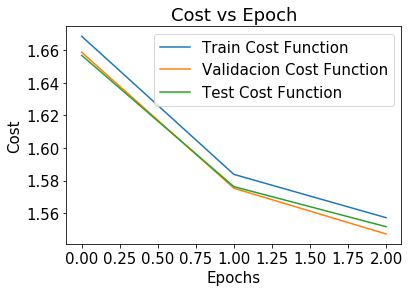

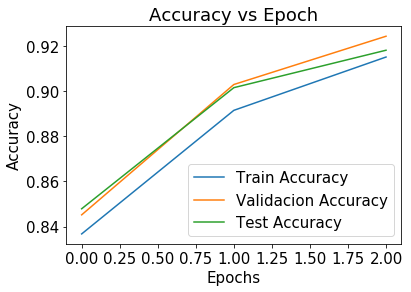

Confusion matrix, without normalization
50283 0.9142363636363636


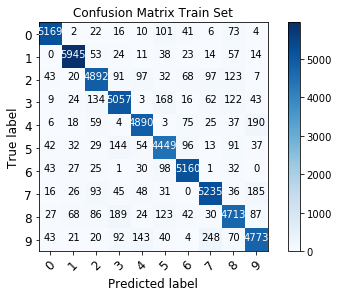

Confusion matrix, without normalization
4603 0.9206


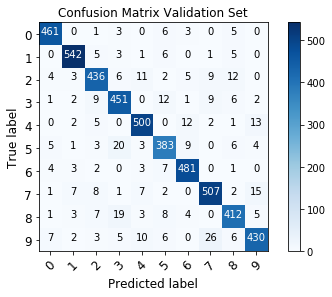

Confusion matrix, without normalization
9201 0.9201


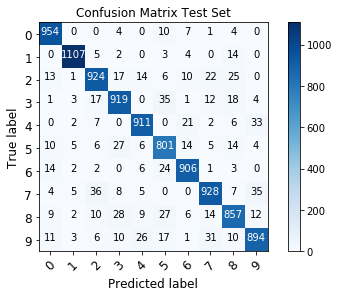

SystemExit: 

C:\Users\bldr1\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
# Función que realiza la fase de ejecución
def main(mnist_data):
    # Importar datos
    batch_size = 100
    epochs = 30
    mnist = input_data.read_data_sets(FLAGS.data_dir, one_hot=True)
    initial_time = time.time()
    print("Size of:")
    print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
    print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
    print("- Validation-set:\t{}".format(len(mnist.validation.labels)))
    
    train_accu = []
    val_accu = []
    test_accu = []
    costo_train = []
    costo_val = []
    costo_test = []

    # Inputs, etiquetas, y output de la red convolucional
    x = tf.placeholder(tf.float32, [None,28*28])

    y_ = tf.placeholder(tf.int64, [None,10])
    y_true_cls = tf.argmax(y_,dimension=1)

    y_conv, keep_prob = deepnn(x)
        
   
    # Función objetivo, optimizador y evaluación
    with tf.name_scope('loss'):
        cross_entropy = cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)
    cross_entropy = tf.reduce_mean(cross_entropy)

    with tf.name_scope('my_optimizer'):
        train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_true_cls)
        correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    
    with tf.name_scope('prediction'):
        cls = tf.argmax(y_conv, 1)
        

    graph_location = tempfile.mkdtemp()
    print('Saving graph to: %s' % graph_location)
    train_writer = tf.summary.FileWriter(graph_location)
    train_writer.add_graph(tf.get_default_graph())

   
    # Ejecutar la sesión que entrena la red convolucional
    with tf.Session() as sess:
        #Inicialice las variables
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            train_accuracy = 0
            for i in range( int(len(mnist.train.labels)/batch_size) ):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                train_step.run(feed_dict={x: X_batch , y_: y_batch})                
            
            print('step {}'.format(epoch))
            
            train_accuracy = sess.run(accuracy,feed_dict={x: mnist.train.images, y_: mnist.train.labels})
            print('\t training set accuracy \t\t\t %g' % (train_accuracy))
            
            validation_accuracy = sess.run(accuracy,feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
            print('\t validation set accuracy \t\t %g' % validation_accuracy)
            
            test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            print('\t test set accuracy \t\t\t %g' % test_accuracy)
            
            costo_train.append(sess.run(cross_entropy, feed_dict={x: mnist.train.images, y_: mnist.train.labels}))
            costo_val.append(sess.run(cross_entropy, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels}))
            costo_test.append(sess.run(cross_entropy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
            train_accu.append(train_accuracy)
            val_accu.append(validation_accuracy)
            test_accu.append(test_accuracy)
                # El argumento keep_prob indica la probabilidad de mantener un nodo de input
                # (es dropout aplicado al input)
        minutos = int((time.time() - initial_time)/60)
        print('TRAINING TIME(MIN): {}'.format(minutos))
        y_pred = sess.run(cls, feed_dict={x: mnist.train.images, y_: mnist.train.labels})
        cnf_matrix_train = confusion_matrix([np.argmax(x) for x in mnist.train.labels], y_pred)
        
        
        y_pred = sess.run(cls, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
        cnf_matrix_val = confusion_matrix([np.argmax(x) for x in mnist.validation.labels], y_pred)        
        
        y_pred = sess.run(cls, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        cnf_matrix_test = confusion_matrix([np.argmax(x) for x in mnist.test.labels], y_pred) 
        
        iteration = np.arange(len(costo_train))
        plt.plot(iteration,costo_train, label = 'Train Cost Function')
        plt.plot(iteration,costo_val, label = 'Validacion Cost Function')
        plt.plot(iteration,costo_test, label = 'Test Cost Function')
        plt.legend(fontsize=15)
        plt.xlabel('Epochs', fontsize=15)
        plt.ylabel('Cost', fontsize=15)
        plt.title('Cost vs Epoch', fontsize=18)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.figure(figsize=(20,10))
        plt.show()
        
        plt.plot(iteration,train_accu, label = 'Train Accuracy')
        plt.plot(iteration,val_accu, label = 'Validacion Accuracy')
        plt.plot(iteration,test_accu, label = 'Test Accuracy')
        plt.legend(fontsize=15)
        plt.xlabel('Epochs', fontsize=15)
        plt.ylabel('Accuracy', fontsize=15)
        plt.title('Accuracy vs Epoch', fontsize=18)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.figure(figsize=(20,10))
        plt.show()
        
        plot_confusion_matrix(cnf_matrix_train,classes = ['0','1','2','3','4','5','6','7','8','9'],
                         title='Confusion Matrix Train Set')
        plt.show()

        plot_confusion_matrix(cnf_matrix_val,classes = ['0','1','2','3','4','5','6','7','8','9'],
                                 title='Confusion Matrix Validation Set')
        plt.show()
        plot_confusion_matrix(cnf_matrix_test,classes = ['0','1','2','3','4','5','6','7','8','9'],
                                 title='Confusion Matrix Test Set')
        plt.show()
        
            
# Esta parte del código ejecuta la función main(). No necesitas modificarla
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str,
                      default='/tmp/tensorflow/mnist/input_data',
                      help='Directory for storing input data')
    FLAGS, unparsed = parser.parse_known_args()
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

### 4) Resultados

Muestre curvas de aprendizaje (e.g., pérdida en función de épocas), comparación entre los distintos sets, matrices de confusión y análisis de error en el resultado

## Proyecto (25%)

Defina sucintamente el objetivo de su proyecto, enmárquelo en alguna de las temáticas del curso (regresión, clasificación, clustering, reducción de dimensionalidad, etc.) e identifique sus datos con la notación vista en clase (e.g., defina sus _inputs_ y _labels_ si su problema es de clasificación). Además, explore las herramientas clásicas para resolver su problema e implemente al menos una con sus datos. 

Extensión máxima para esta parte: **2 páginas**.